# Voter separation


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
from importlib import reload
import sys

sys.path.append("..")
from src import vote_utils as vu
from src import dissimilarity_analysis as da

vu = reload(vu)
plt.rcParams["figure.dpi"] = 300

%matplotlib inline

## Last available data

  0%|          | 0/13029 [00:00<?, ?it/s]

dict_keys(['df_data_boxes', 'df_data', 'fig_latest_point'])

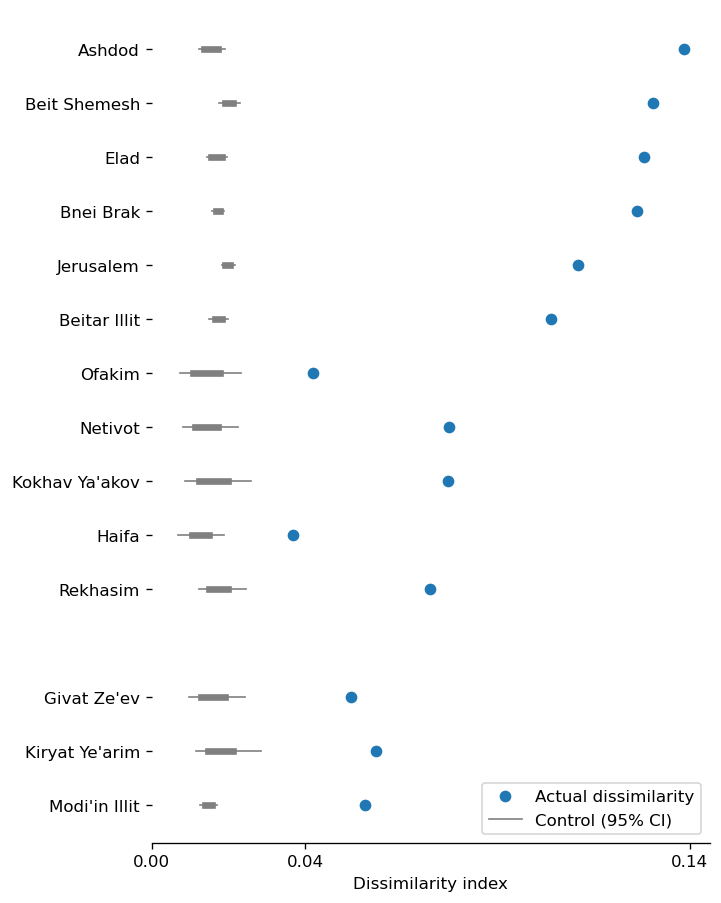

In [2]:
dct = da.main(knesset_numbers=list(range(15, 26)))
df_data_all = dct["df_data"].copy()
df_data = df_data_all.loc[
    df_data_all.knesset_number == df_data_all.knesset_number.max()
].copy()
dct.keys()

In [3]:
df_data_boxes = dct["df_data_boxes"].copy()
bb = df_data_boxes.loc[
    (df_data_boxes.knesset_number == 25) & (df_data_boxes.city_code == "6100")
][["party_shas", "party_agudat_israel"]].sum()
bb = bb / bb.sum() * 100
bb

party_shas             33.54079
party_agudat_israel    66.45921
dtype: float64

In [4]:
df_data

,knesset_number,city_code,city_name,n_boxes,n_voters,n_legal,n_relevant_boxes,n_relevant_voters,n_relevant_legal,city_ref_ratio,...,dissimilarity,dissimilarity_simulation,simulation_fraction,y_city,y_knesset,y,n_haredi_population,fraction_haredim,fraction_haredim_of_jewish_population,fraction_of_total_haredim_in_israel
0,25,3797,Modi'in Illit,53,32933,26655,53,32933,26655,0.255396,...,0.055653,"[0.015528143173985504, 0.014288038689551976, 0...",0.0,0,-0.0,0.0,83168,0.998,0.997924,0.069956
7,25,1137,Kiryat Ye'arim,7,3496,2703,7,3496,2703,0.354525,...,0.058361,"[0.021848826063022186, 0.02337477741686595, 0....",0.0,1,-0.0,1.0,6390,0.975,0.977662,0.005375
16,25,3730,Givat Ze'ev,21,12613,9663,5,2598,2215,0.572342,...,0.051922,"[0.019930724494220897, 0.011443739742833631, 0...",0.0,2,-0.0,2.0,11724,0.556,0.560796,0.009862
19,25,922,Rekhasim,12,6974,5837,12,6974,5837,1.148425,...,0.072335,"[0.011917068668250097, 0.018036334281080535, 0...",0.0,4,-0.0,4.0,13295,0.936,0.937985,0.011183
26,25,4000,Haifa,424,253292,139764,5,2893,1926,0.097495,...,0.036794,"[0.017389109315127448, 0.009920722262921232, 0...",0.0,5,-0.0,5.0,17332,0.060,0.081628,0.014579
33,25,3779,Kokhav Ya'akov,9,5005,4016,5,2863,2391,1.827540,...,0.077210,"[0.012152219501022094, 0.013968121687510849, 0...",0.0,6,-0.0,6.0,6708,0.685,0.685259,0.005642
35,25,246,Netivot,51,28166,21185,6,3803,3221,2.468940,...,0.077379,"[0.008488876655176647, 0.016718617902896825, 0...",0.0,7,-0.0,7.0,20532,0.443,0.458140,0.017270
38,25,31,Ofakim,41,23916,16284,5,3174,2568,0.788651,...,0.041992,"[0.014650463116664231, 0.016832364133714584, 0...",0.0,8,-0.0,8.0,10716,0.302,0.325378,0.009014
45,25,3780,Beitar Illit,49,29318,23688,49,29318,23688,0.518642,...,0.103814,"[0.015571689550978417, 0.016513000741660972, 0...",0.0,9,-0.0,9.0,63606,0.994,0.993797,0.053502
52,25,3000,Jerusalem,706,432125,264700,202,123662,79019,0.490935,...,0.110863,"[0.018889251494145207, 0.018431218471124076, 0...",0.0,10,-0.0,10.0,290090,0.295,0.499097,0.244008


In [5]:
column_rename_dict = {
    "knesset_number": "Knesset Number",
    "city_code": "City Code",
    "city_name": "City Name",
    "n_boxes": "Number of Voting Boxes",
    "n_voters": "Number of Voters",
    "n_legal": "Number of Legal Voters",
    "n_relevant_boxes": "Number of Haredi Voting Boxes",
    "n_relevant_voters": "Number of Haredi Voters",
    "n_relevant_legal": "Number of Haredi Legal Votes",
    "city_ref_ratio": "City Reference Ratio",
    "city_ratios": "City Ratios",
    "dissimilarity": "Dissimilarity Index",
    "dissimilarity_simulation": "Dissimilarity Simulation",
    "simulation_fraction": "Simulation Fraction",
    "n_haredi_population": "Haredi Population",
    "fraction_haredim": "Fraction of Haredim Within the City Population",
    "fraction_haredim_of_jewish_population": "Fraction of Haredim in Jewish Population",
    "fraction_of_total_haredim_in_israel": "Fraction of Total Haredim in Israel",
    "ratio_haredi_to_total_boxes": "Ratio of Haredi-Total Voting Boxes",
    "ratio_haredi_to_total_voters": "Ratio of Haredi-Total Voters",
    "ratio_haredi_to_total_legal": "Ratio of Haredi-Total Legal Votes",
}

In [ ]:
df_display = (
    df_data[
        [
            "city_name",
            "dissimilarity",
            "n_boxes",
            "n_legal",
            "n_haredi_population",
            "city_ref_ratio",
            "fraction_haredim",
            "n_relevant_boxes",
            "n_relevant_legal",
        ]
    ]
    .sort_values("dissimilarity", ascending=False)
    .rename(columns=column_rename_dict)
    .round(3)
)
df_display.to_clipboard()
df_display

,City Name,Dissimilarity Index,Number of Voting Boxes,Number of Legal Voters,Haredi Population,City Reference Ratio,Fraction of Haredim Within the City Population,Number of Haredi Voting Boxes,Number of Haredi Legal Votes
94,Ashdod,0.139,302,116294,48626,0.374,0.214,30,15277
85,Beit Shemesh,0.130,133,51275,115398,0.436,0.746,63,23530
74,Elad,0.128,39,19637,46058,1.383,0.931,36,18231
63,Bnei Brak,0.126,187,87692,202959,0.471,0.929,170,80933
52,Jerusalem,0.111,706,264700,290090,0.491,0.295,202,79019
45,Beitar Illit,0.104,49,23688,63606,0.519,0.994,49,23688
35,Netivot,0.077,51,21185,20532,2.469,0.443,6,3221
33,Kokhav Ya'akov,0.077,9,4016,6708,1.828,0.685,5,2391
19,Rekhasim,0.072,12,5837,13295,1.148,0.936,12,5837
7,Kiryat Ye'arim,0.058,7,2703,6390,0.355,0.975,7,2703


In [7]:
np.percentile(df_data.city_ref_ratio, [0.25, 0.5, 0.75])  # shas / aguad

array([0.10262672, 0.10775852, 0.11289031])

In [8]:
summary = {
    "total haredi population": f"{int(df_data.n_haredi_population.sum()):,d}",
    "total_voters": f"{int(df_data.n_voters.sum()):,d}",
    "total legal votes": f"{int(df_data.n_legal.sum()):,d}",
    "total boxes": f"{int(df_data.n_boxes.sum()):,d}",
    "shas / utj voters": np.percentile(df_data.city_ref_ratio, [0.05, 0.5, 0.95]).round(
        3
    ),  # shas / aguad
}
summary

{'total haredi population': '936,602',
 'total_voters': '1,226,667',
 'total legal votes': '789,393',
 'total boxes': '2,034',
 'shas / utj voters': array([0.099, 0.108, 0.117])}

### Factor analysis

#### Regression analysis

In [9]:
cols = [
    "knesset_number",
    "city_code",
    "city_name",
    "n_boxes",
    "n_voters",
    "n_legal",
    "n_relevant_boxes",
    "n_relevant_voters",
    "n_relevant_legal",
    "dissimilarity",
    "n_haredi_population",
    # "fraction_haredim_of_jewish_population",
]
df_analysis = df_data[cols].copy().set_index(["knesset_number", "city_code"])
cols_relevant = [c for c in df_analysis.columns if "n_relevant" in c]
for col in cols_relevant:
    col_ref = col.replace("n_relevant", "n")
    col_ratio = col.replace("n_relevant", "ratio_haredi_to_total")
    df_analysis[col_ratio] = df_analysis[col] / df_analysis[col_ref]


df_analysis.head()

city_name  n_boxes  n_voters  n_legal  \
knesset_number city_code                                               
25             3797        Modi'in Illit       53     32933    26655   
               1137       Kiryat Ye'arim        7      3496     2703   
               3730          Givat Ze'ev       21     12613     9663   
               922              Rekhasim       12      6974     5837   
               4000                Haifa      424    253292   139764   

                          n_relevant_boxes  n_relevant_voters  \
knesset_number city_code                                        
25             3797                     53              32933   
               1137                      7               3496   
               3730                      5               2598   
               922                      12               6974   
               4000                      5               2893   

                          n_relevant_legal  dissimilarity  \
knesset_number city_code                                    
25             3797                  26655       0.055653   
               1137                   2703       0.058361   
               3730                   2215       0.051922   
               922                    5837       0.072335   
               4000                   1926       0.036794   

                          n_haredi_population  ratio_haredi_to_total_boxes  \
knesset_number city_code                                                     
25             3797                     83168                     1.000000   
               1137                      6390                     1.000000   
               3730                     11724                     0.238095   
               922                      13295                     1.000000   
               4000                     17332                     0.011792   

                          ratio_haredi_to_total_voters  \
knesset_number city_code                                 
25             3797                           1.000000   
               1137                           1.000000   
               3730                           0.205978   
               922                            1.000000   
               4000                           0.011422   

                          ratio_haredi_to_total_legal  
knesset_number city_code                               
25             3797                          1.000000  
               1137                          1.000000  
               3730                          0.229225  
               922                           1.000000  
               4000                          0.013780

In [10]:
col_city = "city_name"
col_dissimilarity = "dissimilarity"
cols_rest = [c for c in df_analysis.columns if c not in [col_city, col_dissimilarity]]
#  move 'n_haredi_population' to the end
cols_rest.remove("n_haredi_population")
cols_rest.append("n_haredi_population")
cols_rest.remove("ratio_haredi_to_total_voters")
n_cols = 3
n_rows = int(np.ceil(len(cols_rest) / n_cols))
w = 3

In [11]:
# use statsmodels to perform a linear regression
import statsmodels.api as sm

print(
    "Regression analysis is not a valid method for this data due to the high correlation between the variables"
)
#
# y = df_analysis[col_dissimilarity]
# X = df_analysis[cols_rest].copy()
# cols_log = [c for c in cols_rest if c.startswith("n_")]
# for col in cols_log:
#     X[col] = np.log10(X[col])
# X = sm.add_constant(X)
# X = X.rename(columns={k: v for k, v in column_rename_dict.items() if k in df_analysis.columns})
# # For small sample sizes
# # HC3 is often recommended because it
# # is more robust to influential outliers.
# model = sm.OLS(y, X).fit(cov_type="HC3")
# model.summary()

Regression analysis is not a valid method for this data due to the high correlation between the variables


In [12]:
# # get the cefficient table
# df_coefficients = pd.DataFrame({
#     "coef": model.params,
#     "std_err": model.bse,
#     "t": model.tvalues,
#     "p": model.pvalues,
#     "p_corrected": model.pvalues,
#     'abs_coef': np.abs(model.params),
# }).sort_values('abs_coef', ascending=False)
# df_coefficients

#### Spearman correlation

In [13]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

rho_values = []
p_values = []

for col in cols_rest:
    x = df_analysis[col]
    if col.startswith("n_"):
        x = np.log10(x)
    rho, p = spearmanr(x, df_analysis[col_dissimilarity])
    rho_values.append(rho)
    p_values.append(p)
rho_values = np.array(rho_values)
p_values = np.array(p_values)
# Perform Benjamini-Yekutieli correction
alpha = 0.05
reject, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method="fdr_bh")
df_corr = pd.DataFrame(
    {
        "rho": rho_values,
        "p": p_values,
        "p_corrected": p_values_corrected,
        "reject": reject,
    },
    index=cols_rest,
).sort_values("p_corrected")
df_corr_display = df_corr.copy()
df_corr_display.index = [column_rename_dict.get(c, c) for c in df_corr.index]
df_corr_display.round(3)

,rho,p,p_corrected,reject
Number of Haredi Voting Boxes,0.667,0.009,0.044,True
Number of Haredi Voters,0.653,0.011,0.044,True
Number of Haredi Legal Votes,0.635,0.015,0.044,True
Haredi Population,0.600,0.023,0.052,False
Number of Voting Boxes,0.301,0.296,0.380,False
Number of Voters,0.305,0.288,0.380,False
Number of Legal Voters,0.349,0.221,0.380,False
Ratio of Haredi-Total Voting Boxes,0.064,0.827,0.827,False
Ratio of Haredi-Total Legal Votes,0.064,0.827,0.827,False


In [14]:
df_corr_display.index

Index(['Number of Haredi Voting Boxes', 'Number of Haredi Voters',
       'Number of Haredi Legal Votes', 'Haredi Population',
       'Number of Voting Boxes', 'Number of Voters', 'Number of Legal Voters',
       'Ratio of Haredi-Total Voting Boxes',
       'Ratio of Haredi-Total Legal Votes'],
      dtype='object')

In [43]:
def set_ticks_and_labels(ax, which, values, log_transform=False):
    min_val = values.min()
    max_val = values.max()
    mid_point = (min_val + max_val) / 2
    tks = [min_val, mid_point, max_val]
    if log_transform:
        labels = [
            f"{value:,d}" if value >= 10000 else f"{value:d}"
            for t in tks
            for value in [int(np.round(np.power(10, t), -2))]
        ]
    else:
        labels = [f"{t:.2f}" for t in tks]
    if which == "x":
        ax.set_xticks(tks)
        ax.set_xticklabels(labels)
    elif which == "y":
        ax.set_yticks(tks)
        ax.set_yticklabels(labels)
    return ax


def my_regplot(data, x_col, y_col, ax=None, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()

    x = data[x_col]
    if x_col.startswith("n_"):
        log_transform = True
        x = np.log10(x)
    else:
        log_transform = False
    y = data[y_col]
    sns.regplot(x=x, y=y, data=data, ax=ax, color=color)
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(ax=ax)
    ax.grid(False)
    set_ticks_and_labels(ax, "x", x, log_transform=log_transform)
    set_ticks_and_labels(ax, "y", y)

    return ax

In [46]:
w

3

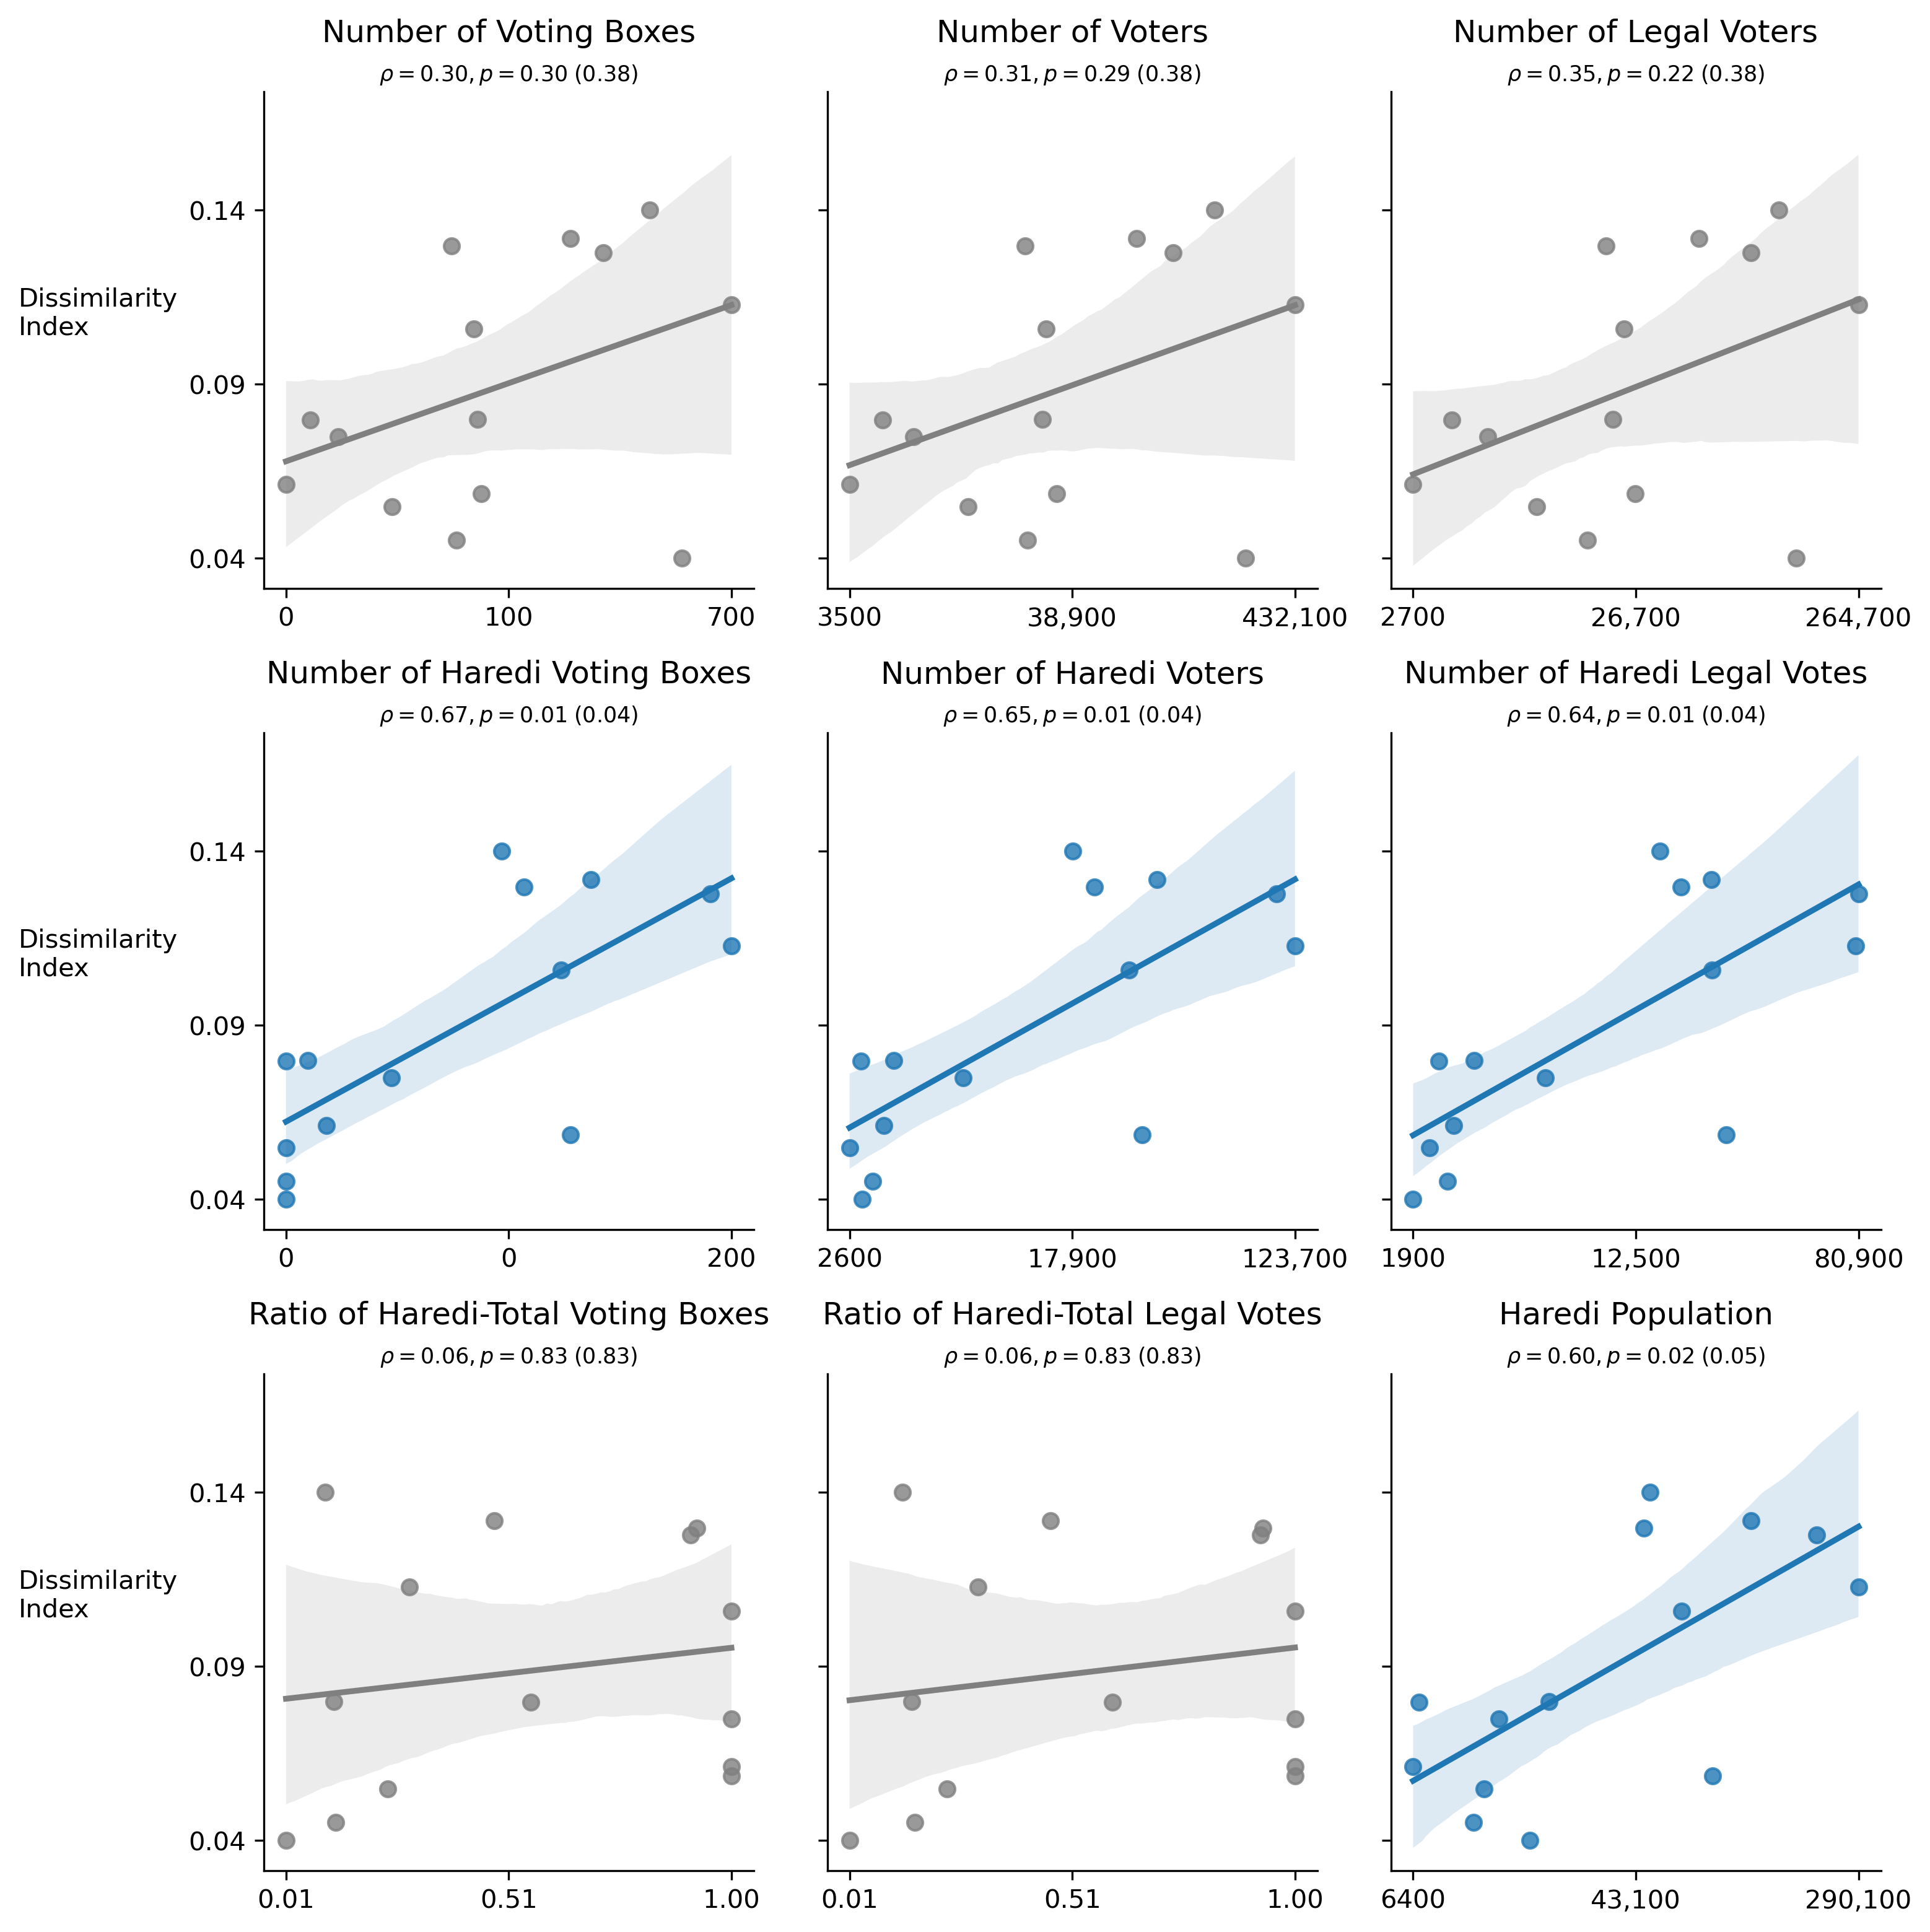

In [ ]:
w = 3.5
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * w, n_rows * w),
    sharey=True,
)
axes = axes.flatten()

for i, col in enumerate(cols_rest):
    ax = axes[i]

    rho = df_corr.loc[col, "rho"]
    p = df_corr.loc[col, "p"]
    p_corr = df_corr.loc[col, "p_corrected"]
    reject = df_corr.loc[col, "reject"]
    color = "C0" if p < 0.05 else "gray"

    my_regplot(df_analysis, col, col_dissimilarity, ax=ax, color=color)
    col_name = column_rename_dict.get(col, col)
    ttl = f"{col_name}\n$_{{ρ={rho:.2f}, p={p:.2f} \\; ({p_corr:.2f})}}$"
    ax.set_title(ttl)

    # Set Y label only on leftmost axes
    if i % n_cols != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Dissimilarity\nIndex", rotation=0, ha="right", ma="left")

# Clean up any unused axes
for i in range(len(cols_rest), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
fig.tight_layout()

In [18]:
# fn_translations = os.path.join( "/Users/boris/devel/jce/segregation/data/external/israeli_cities_hebrew_english.csv")
# df_translations = pd.read_csv(fn_translations).set_index("city_name")

In [19]:
# fn_demographics = '/Users/boris/devel/jce/segregation/data/external/haredi_population_by_city.xlsx'
# df_demographics = pd.read_excel(fn_demographics, skiprows=4).rename(columns={'Unnamed: 1': 'city_name'}).drop(columns='Unnamed: 0').dropna().rename(columns= {
#     "אוכלוסייה חרדית ביישוב": "haredi_population",
#     "שיעור החרדים ביישוב": "fraction_haredim",
#     "שיעור החרדים מהאוכלוסייה היהודית ביישוב": "fraction_haredim_of_jewish_population",
#     "שיעור מכלל החרדים בישראל": "fraction_of_total_haredim_in_israel"
# })
# df_demographics.city_name = df_translations.loc[df_demographics.city_name, 'city_name_english'].values
#
# df_demographics

## Separation dynamics

In [20]:
df_data_all

,knesset_number,city_code,city_name,n_boxes,n_voters,n_legal,n_relevant_boxes,n_relevant_voters,n_relevant_legal,city_ref_ratio,...,dissimilarity,dissimilarity_simulation,simulation_fraction,y_city,y_knesset,y,n_haredi_population,fraction_haredim,fraction_haredim_of_jewish_population,fraction_of_total_haredim_in_israel
0,25,3797,Modi'in Illit,53,32933,26655,53,32933,26655,0.255396,...,0.055653,"[0.015528143173985504, 0.014288038689551976, 0...",0.0,0,-0.00,0.00,83168,0.998,0.997924,0.069956
1,24,3797,Modi'in Illit,61,30528,24369,61,30528,24369,0.221658,...,0.061279,"[0.014684161503140777, 0.018054287086379895, 0...",0.0,0,0.15,0.15,83168,0.998,0.997924,0.069956
2,23,3797,Modi'in Illit,45,28796,23653,45,28796,23653,0.228680,...,0.048692,"[0.015181703681251624, 0.013444043850857934, 0...",0.0,0,0.30,0.30,83168,0.998,0.997924,0.069956
3,22,3797,Modi'in Illit,43,27973,23167,43,27973,23167,0.219983,...,0.050276,"[0.013343282986491772, 0.012741866626869798, 0...",0.0,0,0.45,0.45,83168,0.998,0.997924,0.069956
4,21,3797,Modi'in Illit,41,27232,22385,41,27232,22385,0.212850,...,0.040375,"[0.012640012452711924, 0.013956488258270656, 0...",0.0,0,0.60,0.60,83168,0.998,0.997924,0.069956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,19,70,Ashdod,278,166360,103274,23,14031,12429,0.449090,...,0.201763,"[0.015729492786467215, 0.015800157697036184, 0...",0.0,14,0.90,14.90,48626,0.214,0.241661,0.040902
103,18,70,Ashdod,257,156977,94776,18,10851,9286,0.537610,...,0.213399,"[0.019518278623945975, 0.018984513780747763, 0...",0.0,14,1.05,15.05,48626,0.214,0.241661,0.040902
104,17,70,Ashdod,243,86978,85164,16,9072,9027,0.475304,...,0.188243,"[0.019958259276681326, 0.011903503299914124, 0...",0.0,14,1.20,15.20,48626,0.214,0.241661,0.040902
105,16,70,Ashdod,170,115848,86388,9,5826,5374,0.617090,...,0.186044,"[0.016564771300408468, 0.016332058642603432, 0...",0.0,14,1.35,15.35,48626,0.214,0.241661,0.040902


In [21]:
def make_step_plot(df, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    x = df.election_date
    y = df.dissimilarity
    ax.step(x, y, "-o", where="post")
    sns.despine(ax=ax)
    return ax

In [22]:
if "election_date" not in df_data_all.columns:
    df_dates = pd.read_csv("../data/external/election_dates.csv").set_index(
        "knesset_number", drop=True
    )
    df_dates["election_date"] = pd.to_datetime(df_dates["election_date"])
    df_data_all["election_date"] = df_dates.reindex(df_data_all.knesset_number.values)[
        "election_date"
    ].values
df_data_all

,knesset_number,city_code,city_name,n_boxes,n_voters,n_legal,n_relevant_boxes,n_relevant_voters,n_relevant_legal,city_ref_ratio,...,dissimilarity_simulation,simulation_fraction,y_city,y_knesset,y,n_haredi_population,fraction_haredim,fraction_haredim_of_jewish_population,fraction_of_total_haredim_in_israel,election_date
0,25,3797,Modi'in Illit,53,32933,26655,53,32933,26655,0.255396,...,"[0.015528143173985504, 0.014288038689551976, 0...",0.0,0,-0.00,0.00,83168,0.998,0.997924,0.069956,2022-11-01
1,24,3797,Modi'in Illit,61,30528,24369,61,30528,24369,0.221658,...,"[0.014684161503140777, 0.018054287086379895, 0...",0.0,0,0.15,0.15,83168,0.998,0.997924,0.069956,2021-03-23
2,23,3797,Modi'in Illit,45,28796,23653,45,28796,23653,0.228680,...,"[0.015181703681251624, 0.013444043850857934, 0...",0.0,0,0.30,0.30,83168,0.998,0.997924,0.069956,2020-03-02
3,22,3797,Modi'in Illit,43,27973,23167,43,27973,23167,0.219983,...,"[0.013343282986491772, 0.012741866626869798, 0...",0.0,0,0.45,0.45,83168,0.998,0.997924,0.069956,2019-09-17
4,21,3797,Modi'in Illit,41,27232,22385,41,27232,22385,0.212850,...,"[0.012640012452711924, 0.013956488258270656, 0...",0.0,0,0.60,0.60,83168,0.998,0.997924,0.069956,2019-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,19,70,Ashdod,278,166360,103274,23,14031,12429,0.449090,...,"[0.015729492786467215, 0.015800157697036184, 0...",0.0,14,0.90,14.90,48626,0.214,0.241661,0.040902,2013-01-22
103,18,70,Ashdod,257,156977,94776,18,10851,9286,0.537610,...,"[0.019518278623945975, 0.018984513780747763, 0...",0.0,14,1.05,15.05,48626,0.214,0.241661,0.040902,2009-02-10
104,17,70,Ashdod,243,86978,85164,16,9072,9027,0.475304,...,"[0.019958259276681326, 0.011903503299914124, 0...",0.0,14,1.20,15.20,48626,0.214,0.241661,0.040902,2006-03-28
105,16,70,Ashdod,170,115848,86388,9,5826,5374,0.617090,...,"[0.016564771300408468, 0.016332058642603432, 0...",0.0,14,1.35,15.35,48626,0.214,0.241661,0.040902,2003-01-28


In [23]:
df_summary = df_data_all.groupby("city_name").apply(
    lambda d: pd.Series(
        {
            "n_points": len(d),
            "last_value": d.sort_values("knesset_number")["dissimilarity"].iloc[-1],
        }
    )
)
df_summary = (
    df_summary.loc[df_summary.n_points > 5]
    .sort_values("last_value", ascending=True)
    .reset_index()
)
df_summary

/var/folders/xy/6n3m38qx423b_gjbx89x02b40000gn/T/ipykernel_34216/4173167041.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_summary = df_data_all.groupby("city_name").apply(


,city_name,n_points,last_value
0,Ofakim,7.0,0.041992
1,Modi'in Illit,11.0,0.055653
2,Rekhasim,9.0,0.072335
3,Beitar Illit,11.0,0.103814
4,Jerusalem,11.0,0.110863
5,Bnei Brak,11.0,0.126192
6,Elad,9.0,0.128052
7,Beit Shemesh,9.0,0.130353
8,Ashdod,11.0,0.138561


In [24]:
# Group by 'knesset_number' and 'election_date' and aggregate the relevant columns
df_table = (
    df_data_all.groupby(["knesset_number", "election_date"])
    .agg({"n_voters": "sum", "n_relevant_boxes": "sum", "n_relevant_voters": "sum"})
    .reset_index()
)

# Rename the columns to be human-readable
df_table.columns = [
    "Knesset Number",
    "Date",
    "Number of Voters",
    "Number of Relevant Boxes",
    "Number of Relevant Voters",
]

# Format numbers with thousand separator
df_table["Number of Voters"] = (
    df_table["Number of Voters"].astype(int).apply(lambda x: f"{x:,}")
)
df_table["Number of Relevant Boxes"] = (
    df_table["Number of Relevant Boxes"].astype(int).apply(lambda x: f"{x:,}")
)
df_table["Number of Relevant Voters"] = (
    df_table["Number of Relevant Voters"].astype(int).apply(lambda x: f"{x:,}")
)

# Copy the table to clipboard
df_table.to_clipboard(index=False)
os.system("say shlemp")
df_table

,Knesset Number,Date,Number of Voters,Number of Relevant Boxes,Number of Relevant Voters
0,15,1999-05-17,"398,874",168,"88,103"
1,16,2003-01-28,"501,576",168,"107,885"
2,17,2006-03-28,"412,922",294,"134,141"
3,18,2009-02-10,"684,823",351,"203,190"
4,19,2013-01-22,"778,041",426,"253,517"
5,20,2015-03-17,"792,353",402,"238,885"
6,21,2019-04-09,"1,109,121",491,"316,034"
7,22,2019-09-17,"1,309,052",545,"344,955"
8,23,2020-03-02,"1,128,360",549,"352,411"
9,24,2021-03-23,"1,189,866",669,"365,846"


In [25]:
df_dynamics = df_data_all.merge(
    df_summary[["city_name", "last_value"]], on="city_name"
).sort_values("knesset_number")

In [26]:
df_dynamics.knesset_number.unique()

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

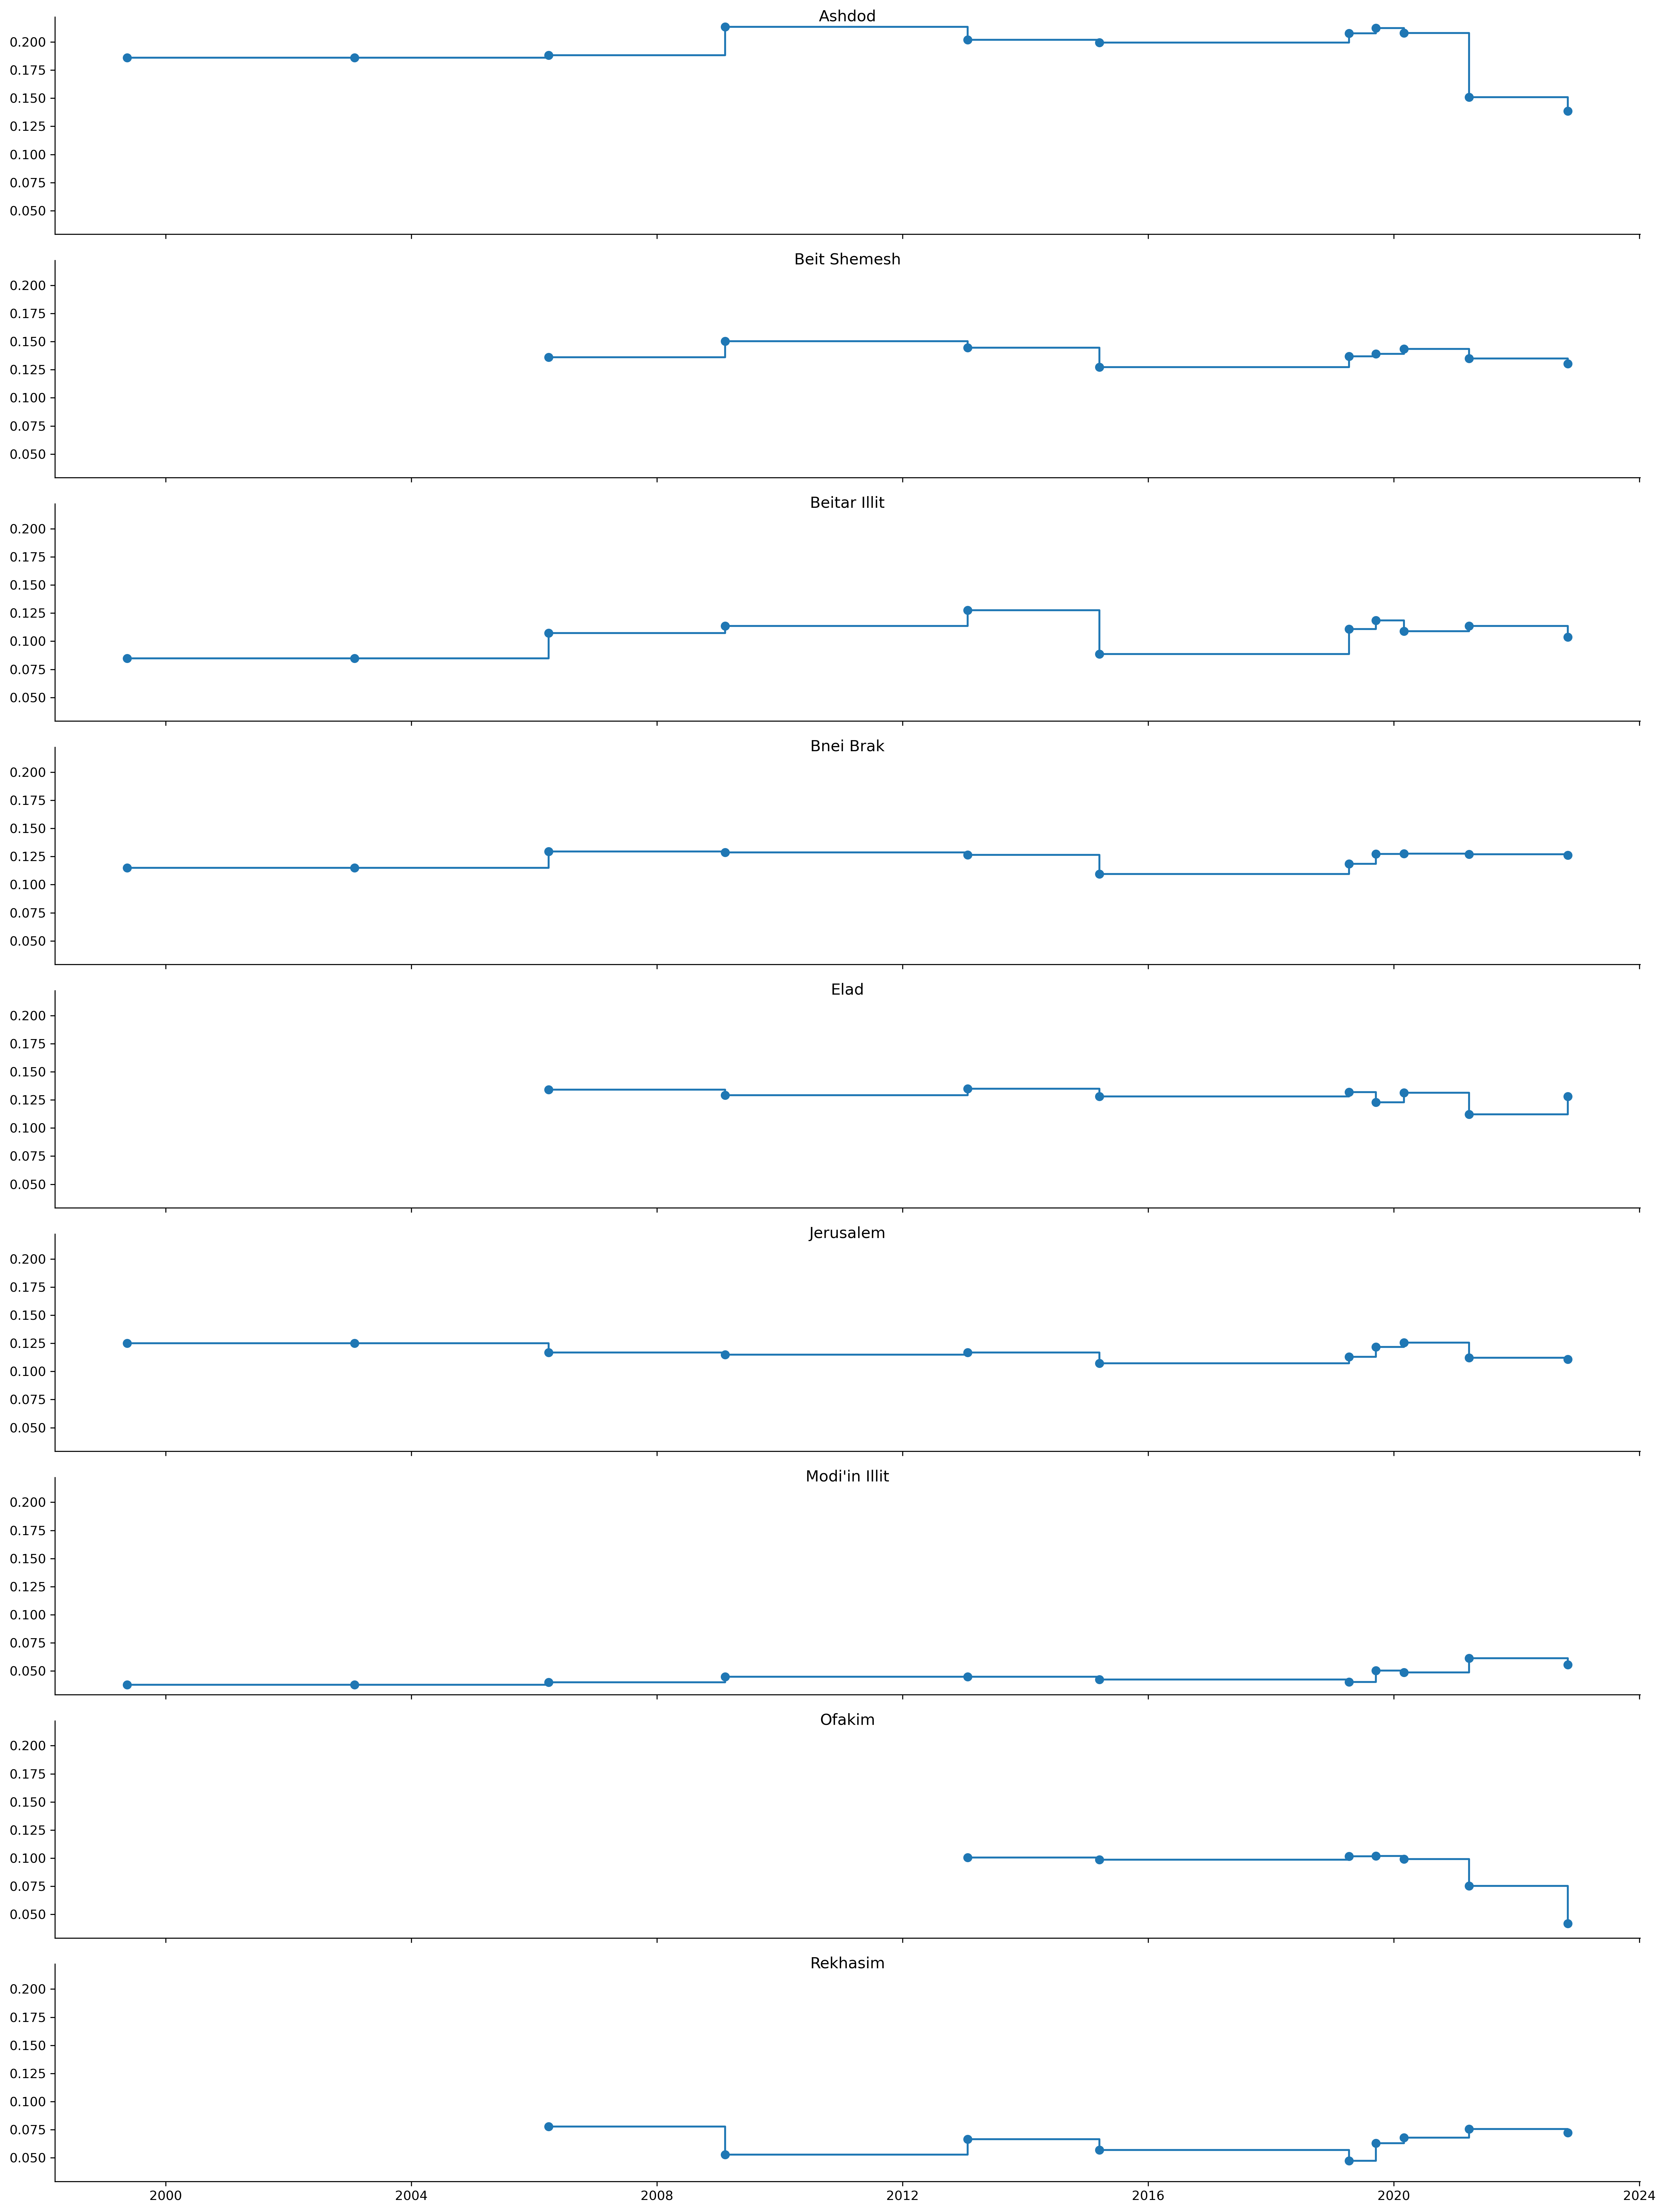

In [27]:
ncols = 1
nrows = int(np.ceil((df_dynamics.city_name.nunique()) // ncols))
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(18, 24))
axes = axes.flatten()
for ax, (city_name, df_city) in zip(axes, df_dynamics.groupby("city_name")):
    make_step_plot(df_city, ax=ax)
    ax.set_title(city_name, y=1, va="top")
fig.tight_layout()

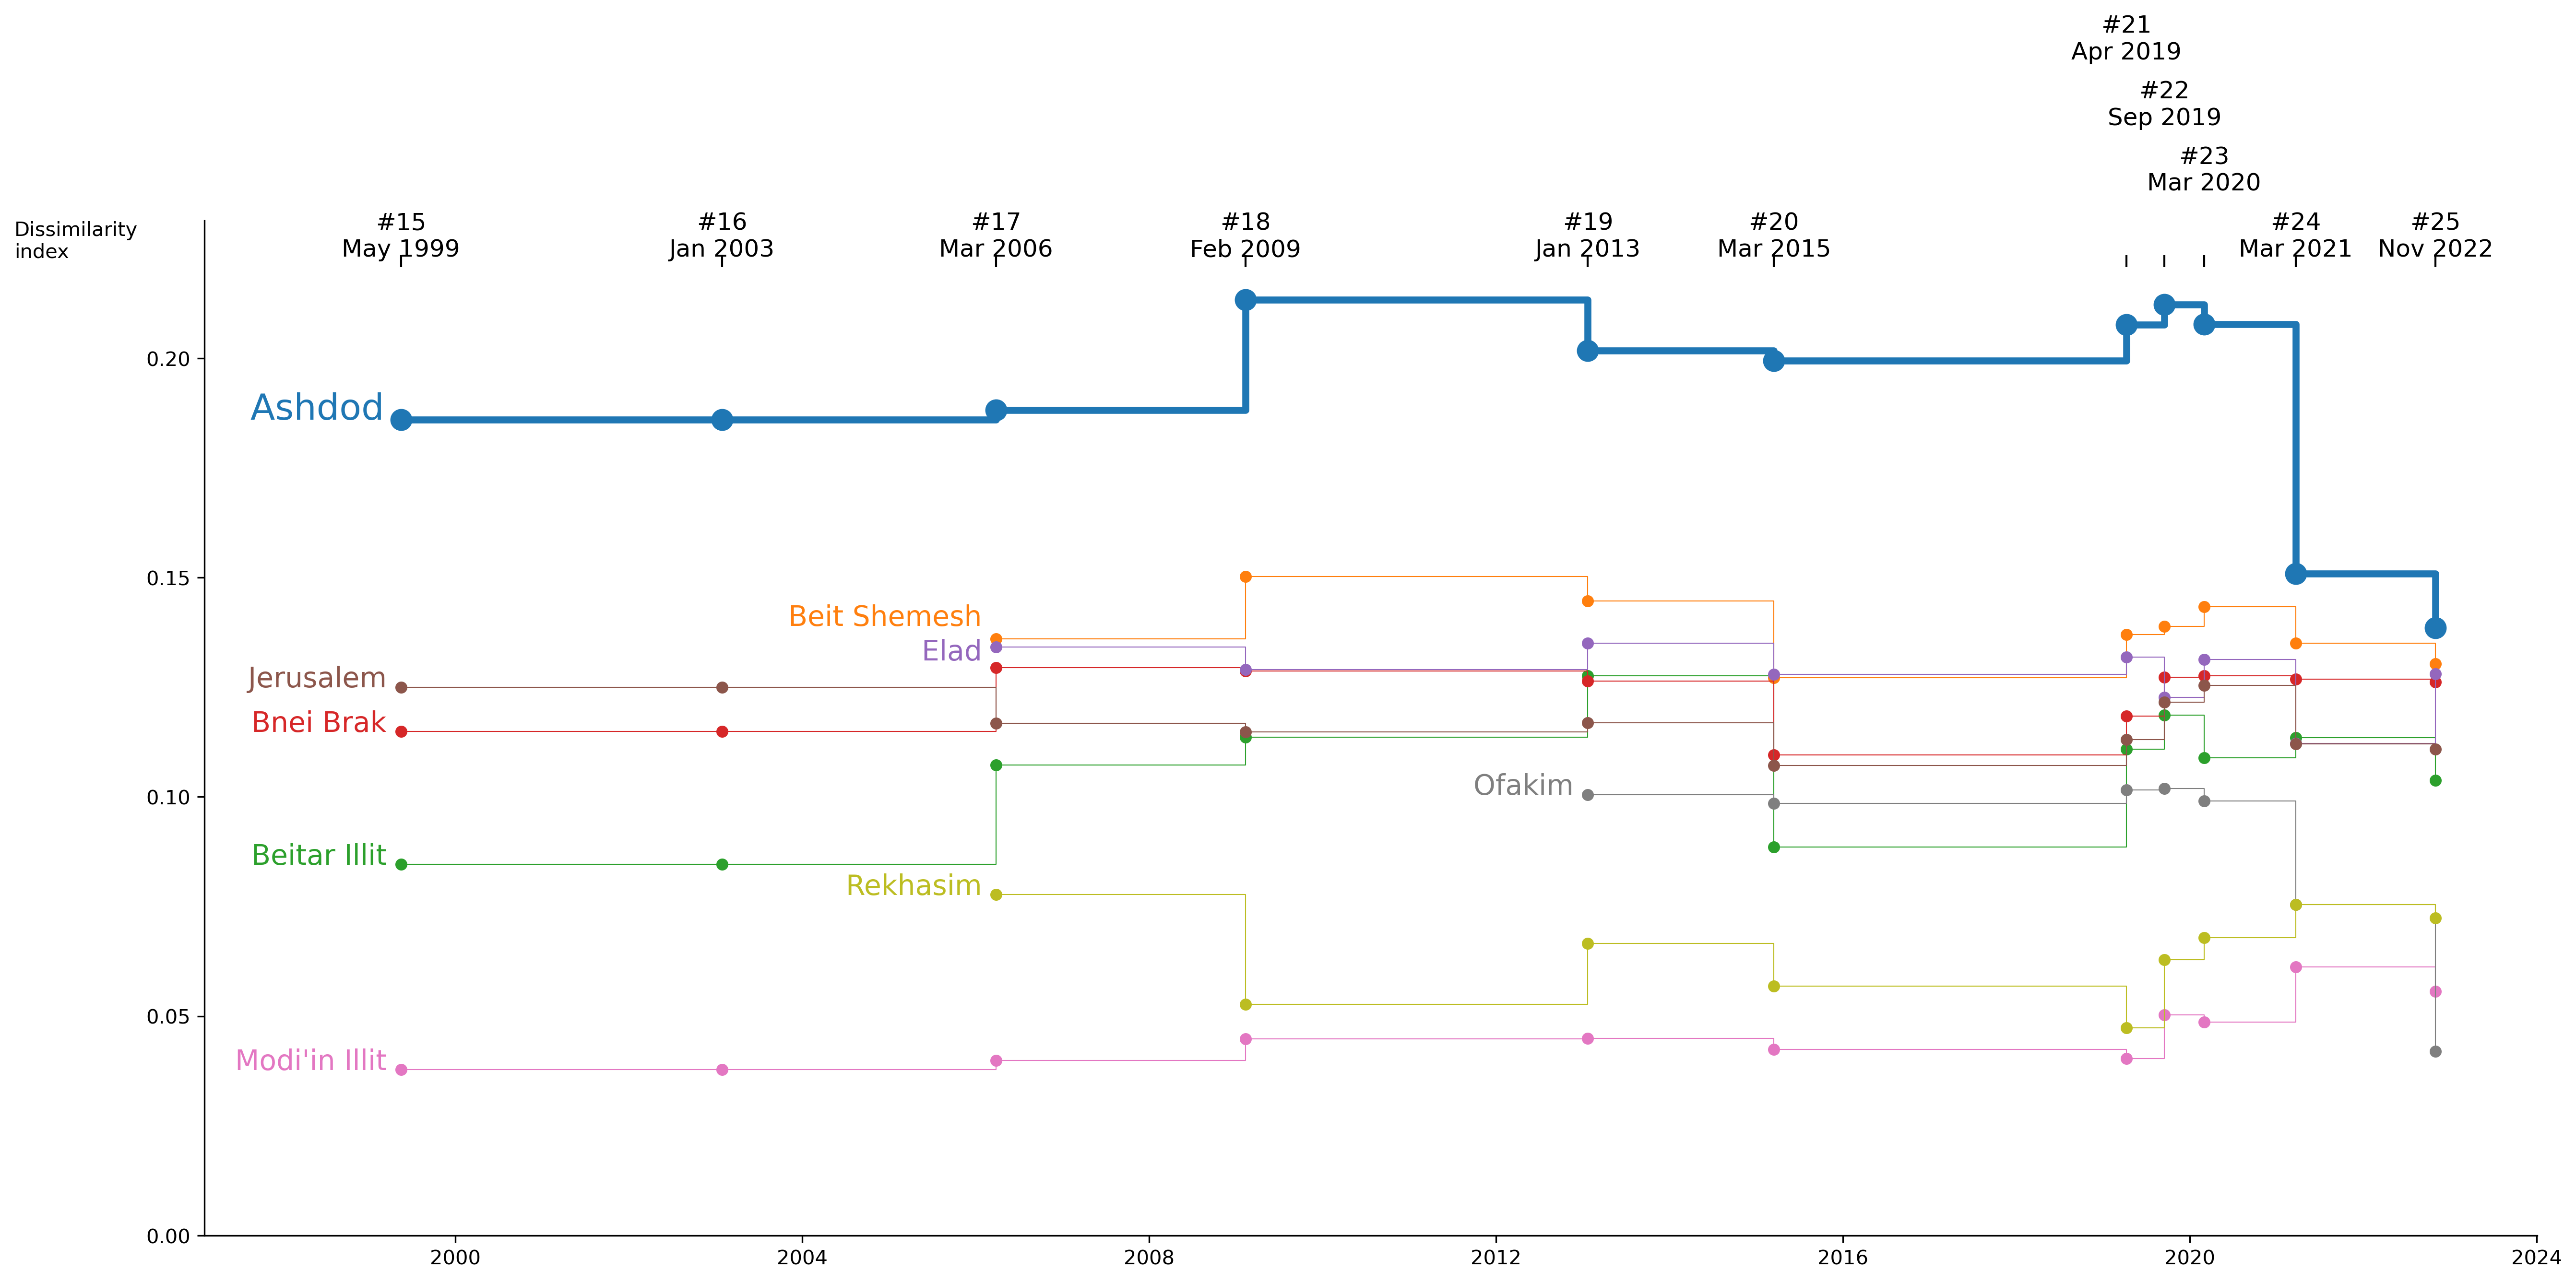

In [42]:
fig, ax = plt.subplots(figsize=(18, 9))
for i, (city_name, df_city) in enumerate(df_dynamics.groupby("city_name")):
    x = df_city.election_date
    y = df_city.dissimilarity
    clr = f"C{i}"
    lw = 3.5 if city_name == "Ashdod" else 0.5
    ms = 10 if city_name == "Ashdod" else 5
    fontsize = 18 if city_name == "Ashdod" else 14
    ax.step(x, y, "-o", where="post", label=city_name, color=clr, lw=lw, ms=ms)
    xx = x.values[0] - int(2e15)
    yy = y.values[0]
    if city_name == "Beit Shemesh":
        yy += 0.003
    elif city_name == "Elad":
        yy -= 0.003
    ax.text(xx, yy, f"{city_name} ", color=clr, ha="right", fontsize=fontsize)

ax.set_xlim((ax.get_xlim()[0] - 100, ax.get_xlim()[-1]))
sns.despine(ax=ax)
ax.grid(False)
y = ax.get_ylim()[-1]
for knesset_number, election_date in df_dates["election_date"].loc[15:].items():
    str_date = election_date.strftime("%b %Y")
    x = election_date
    ax.plot(x, y, "|k")
    if knesset_number in [21, 22, 23]:
        y_corrected = y + (24 - knesset_number) * 0.015
    else:
        y_corrected = y
    ax.text(
        x,
        y_corrected,
        f"#{knesset_number}\n{str_date}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=12,
    )
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_ylabel("Dissimilarity\nindex", ha="right", ma="left", rotation=0, y=1, va="top")
ax.set_xlim((ax.get_xlim()[0] - 300, ax.get_xlim()[-1]))
fig.tight_layout()
fig.savefig("dissimilarity_dynamics.png", dpi=300)
!open dissimilarity_dynamics.png

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (city_name, df_city) in enumerate(df_dynamics.groupby("city_name")):
    x = df_city.election_date
    y = df_city.n_boxes

    clr = f"C{i}"
    ax.step(x, y, "-o", where="post", label=city_name, color=clr)
    xx = x.values[0] - int(2e15)
    yy = y.values[0]
    ax.text(xx, yy, city_name, color=clr, ha="right")

ax.set_xlim((ax.get_xlim()[0] - 100, ax.get_xlim()[-1]))
sns.despine(ax=ax)
ax.grid(False)
y = ax.get_ylim()[-1]
for knesset_number, election_date in df_dates["election_date"].loc[15:].items():
    str_date = election_date.strftime("%b %Y")
    x = election_date
    ax.plot(x, y, "|k")
    if knesset_number in [21, 22, 23]:
        y_corrected = y + (24 - knesset_number) * 40
    else:
        y_corrected = y
    ax.text(
        x,
        y_corrected,
        f"#{knesset_number}\n{str_date}",
        ha="center",
        va="bottom",
        color="black",
    )
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_ylabel(
    "# of haredi\nballot boxes", ha="right", ma="left", rotation=0, y=1, va="top"
)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (city_name, df_city) in enumerate(df_dynamics.groupby("city_name")):
    x = df_city.election_date
    y = df_city.n_voters
    sel_na = y.isna()
    x = x.loc[~sel_na]
    y = y.loc[~sel_na]
    y = y / y.iloc[0] * 100
    clr = f"C{i}"
    ax.step(x, y, "-o", where="post", label=city_name, color=clr)
    xx = x.values[0] - int(2e15)
    yy = y.values[0]
    ax.text(xx, yy, city_name, color=clr, ha="right")

ax.set_xlim((ax.get_xlim()[0] - 100, ax.get_xlim()[-1]))
sns.despine(ax=ax)
ax.grid(False)
y = ax.get_ylim()[-1]
for knesset_number, election_date in df_dates["election_date"].loc[15:].items():
    str_date = election_date.strftime("%b %Y")
    x = election_date
    ax.plot(x, y, "|k")
    ax.text(
        x,
        y * 1.01,
        f"{knesset_number}\n{str_date}",
        ha="center",
        va="bottom",
        color="black",
    )

ax.set_ylabel(
    "% of haredi population\nrelative to 2022",
    ha="right",
    ma="left",
    rotation=0,
    y=1,
    va="top",
)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i, (city_name, df_city) in enumerate(df_dynamics.groupby("city_name")):
    x = df_city.election_date
    y = df_city.n_legal / df_city.n_voters * 100

    clr = f"C{i}"
    ax.step(x, y, "-o", where="post", label=city_name, color=clr)
    xx = x.values[0] - int(2e15)
    yy = y.values[0]
    ax.text(xx, yy, city_name, color=clr, ha="right")

ax.set_xlim((ax.get_xlim()[0] - 100, ax.get_xlim()[-1]))
sns.despine(ax=ax)
ax.grid(False)
y = ax.get_ylim()[-1]
for knesset_number, election_date in df_dates["election_date"].loc[15:].items():
    str_date = election_date.strftime("%b %Y")
    x = election_date
    ax.plot(x, y, "|k")
    ax.text(
        x,
        y * 1.01,
        f"{knesset_number}\n{str_date}",
        ha="center",
        va="bottom",
        color="black",
    )

ax.set_ylabel("% turnout", ha="right", ma="left", rotation=0, y=1, va="top")

In [ ]:
df_dynamics